In [1]:
from routing_game_utils import *

import networkx as nx
from itertools import product
from typing import List, Tuple, Dict
import json
import random
import sympy as sp
import numpy as np

In [2]:
# TODO: fix
def brd_alg(
    G: nx.DiGraph,
    source_sink_pairs: List[Tuple[int, int]],
    demands: List[int],
    latency_functions: Dict,
    max_iterations: int = 1000,
    marginal_cost_pricing: bool = False
):
    # each player's strategy set is represented as a set of available paths from their source to their sink
    paths = get_strategy_sets(G, source_sink_pairs)

    num_players = len(source_sink_pairs)

    # for each player, initialize to 0th strategy (TODO: maybe initialize random)
    current_flow = [0 for _ in range(num_players)]

    converged = False
    iteration = 0

    while not converged and iteration < max_iterations:
        converged = True # assume convergence unless we find a player that wants to change their strategy
        iteration += 1

        f_e, player_latencies, total_latency = calculate_edge_flows(paths, current_flow, demands, latency_functions)

        # for each player, try to see if they can improve their latency by switching paths
        for player_idx in range(num_players):
            current_latency = player_latencies[player_idx]
            current_path_idx = current_flow[player_idx]
            current_path = paths[player_idx][current_path_idx]

            # assume for now that we are picking the best response, but this may update if we find something better
            best_latency = current_latency
            best_path_idx = current_path_idx

            for alternative_path_idx, alternative_path in enumerate(paths[player_idx]):
                if alternative_path_idx == current_path_idx:
                    continue
                hypothetical_f_e = f_e.copy()
                demand = demands[player_idx]

                # Remove player's demand from the paths edges they are currently using
                for i in range(len(current_path) - 1):
                    edge = (current_path[i], current_path[i + 1])
                    hypothetical_f_e[edge] -= demand

                # Add player's demand to alternative path edges
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    hypothetical_f_e[edge] = hypothetical_f_e.get(edge, 0) + demand

                # Compute latency for the alternative path
                alternative_latency = 0
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    flow = hypothetical_f_e[edge]
                    edge_latency = latency_functions[edge](flow)
                    alternative_latency += edge_latency

                # If the alternative latency is better, update best response
                if alternative_latency < best_latency:
                    best_latency = alternative_latency
                    best_path_idx = alternative_path_idx

            # If the best path is different from current, update player's path and set converged to False
            if best_path_idx != current_path_idx:
                current_flow[player_idx] = best_path_idx
                converged = False
                break # found a player who can do better, update that player and try BRD again!

        if iteration >= max_iterations:
            print('reached max iterations')
            
        # at the end, we should've made enough changes to current_flow s.t. it's an equilibrium flow
        f_e, player_latencies, total_latency = calculate_edge_flows(paths, current_flow, demands, latency_functions)

    # paths: strategy sets for each player
    # current_flow: the equilibrium flow. each idx represents a player, each value represents the strategy that the player picked (ex: strategy 0, 1, ...)
    # player_latencies: the latency of each player in the equilibrium flow
    # total latency: sum of player latencies
    return paths, current_flow, player_latencies, total_latency

In [3]:
def braess_paradox_brd():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, equil_flow, player_latencies, min_total_latency = brd_alg(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('player latencies: ', player_latencies)
    print('Equilibrium flows: ', equil_flow)
    print('Minimum total latency: ', min_total_latency)

All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
player latencies:  [3, 4]
Equilibrium flows:  [1, 0]
Minimum total latency:  7


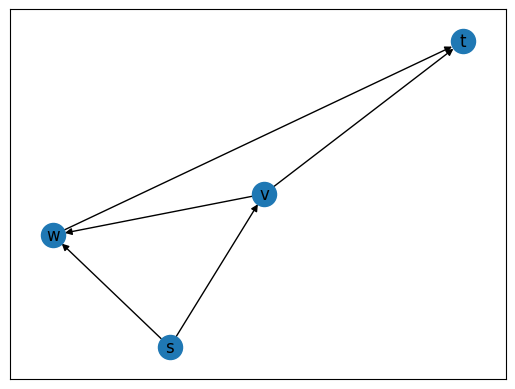

In [4]:
braess_paradox_brd()

In [5]:
def AAE_brd():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/aae_example.txt')
    paths, equil_flow, player_latencies, min_total_latency = brd_alg(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('player latencies: ', player_latencies)
    print('Equilibrium flows: ', equil_flow)
    print('Minimum total latency: ', min_total_latency)

All paths:  [[['u', 'v'], ['u', 'w', 'v']], [['u', 'v', 'w'], ['u', 'w']], [['v', 'u', 'w'], ['v', 'w']], [['w', 'v'], ['w', 'u', 'v']]]
player latencies:  [1, 1, 1, 1]
Equilibrium flows:  [0, 1, 1, 0]
Minimum total latency:  4


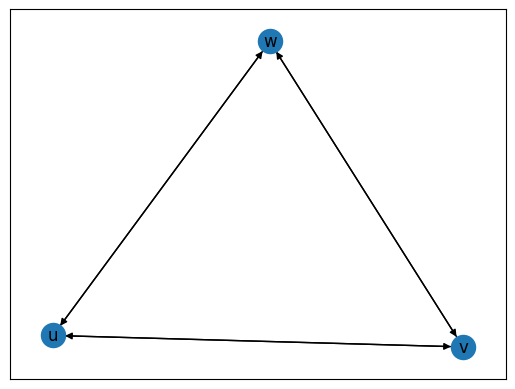

In [6]:
AAE_brd()

In [7]:
def no_equil_brd():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/no_equil.txt')
    paths, equil_flow, player_latencies, min_total_latency = brd_alg(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('player latencies: ', player_latencies)
    print('Equilibrium flows: ', equil_flow)
    print('Minimum total latency: ', min_total_latency)

reached max iterations
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']]]
player latencies:  [47, 60]
Equilibrium flows:  [2, 0]
Minimum total latency:  107


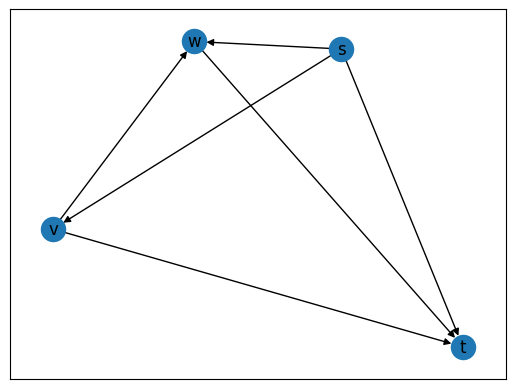

In [8]:
no_equil_brd()